
## Background

Precipitable water vapour (PWV) affects the transmission of light as a function of time. 
The amount absorption observed depends on:
 - the spectral response of the instrument making the observation
 - the spectrum of the target being observed

This tutorial will show you the functions of Umbrella. __Only applicable to observations made from Paranal, Chile at 2400m, or very similar sites, between 0.5 and 2.0 μm. Similarly, only for observations made between airmasses 1 and 3, PWV 0.05 and 30 mm, and targets of effective temperatures between 2000 and 36500 K.__ If you would like to use Umbrella for observations made at other sites, or outside the parameters previously stated, please take a look at the `prePWVGrid generator.ipynb` notebook.

In [2]:
%matplotlib inline
import umbrella
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Preparation

To model the effects of PWV on your data, a grid of all possible atmospheres \[pwv, airmass\] and stellar types \[T<sub>eff</sub>\] one may observe with an instrument should be evaluated. 

To begin, the spectral response (SR) of your instrument must be generated or provided (as a .csv file). This will be a combination of all instrumental efficiencies:

$$\text{SR} = \text{system efficiency} \times \text{filter}$$

It should follow this structure:
<div align=middle><i><br /> 0.4999,0.000
<br /> 0.5000,0.001
<br /> ...
<br /> 0.9001,0.001
<br /> 0.9002,0.000
<br /> ...</i>
</div>
where the first column should be wavelength (microns), second column should be the efficiency value as a fraction.

#### Generating a SR

If you do not have a SR file already generated, you can you use the below cells to generate one. The .csv files provided should follow the same structure as above, with no headers. They do not need to match in resolution.

The SR .csv file generated will follow the same structure as above, interpolated onto a wavelength array of 0.1 nm resolution.

In [3]:
# example files used to generate SR
efficiencyFile = './datafiles/systems/andorSPC_-60.csv'
filterFile = './datafiles/filters/I+z.csv'

# name to refer to the generated file
name = efficiencyFile.split('/')[-1][:-4] + '_' + filterFile.split('/')[-1][:-4]
print(name)

# generates a SR, saved locally as 'name_instrumentSR.csv'
SRFile = './datafiles/SRs/' + name + '_instrumentSR.csv'
umbrella.generateSR(efficiencyFile, filterFile, SRFile)

andorSPC_-60_I+z
./datafiles/SRs/andorSPC_-60_I+z_instrumentSR.csv has been saved!


/Users/peter/Github/umbrella/umbrella.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('tmp', 1)


### Visualising the SR

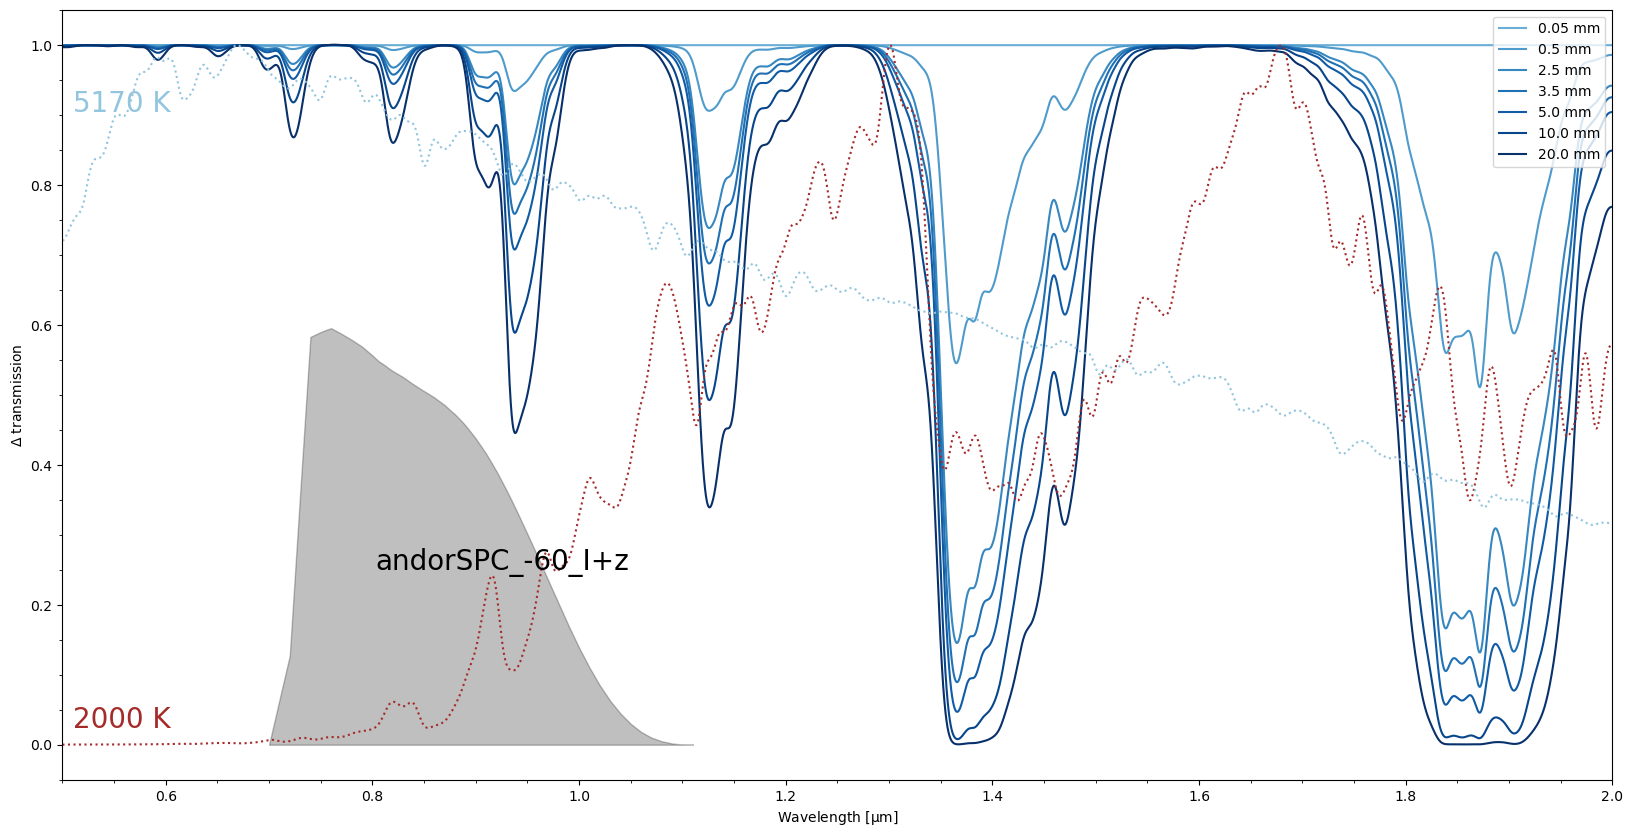

In [4]:
fig, ax = plt.subplots(figsize=(20,10))

## SR
SR = pd.read_csv(SRFile, index_col=0, header=None)
ax.fill_between(SR.index,SR[1],alpha=0.25,color='k')
ax.text(SR.index[int(SR.shape[0]/4)], 0.25, name, rotation=0, fontsize=20, color='k')

## change in transmission
sigma = 50
base = umbrella.getAtmosphere(0.05, 1.0, sigma)
pwv_values = [0.05, 0.5, 2.5, 3.5, 5.0, 10.0, 20.0]
colors = plt.cm.Blues(np.linspace(0.5,1,len(pwv_values)))
for i, pwv in enumerate(pwv_values):
    umbrella.getAtmosphere(pwv, 1.0, sigma).divide(base)['transmission'].plot(ax=ax, color = colors[i], label= str(pwv) + ' mm')

## stellar spectra
umbrella.getStar(2000, sigma)['spectra'].plot(ax=ax, color='brown', alpha=1, linestyle='dotted', label='_None_')
umbrella.getStar(5170, sigma)['spectra'].plot(ax=ax, color='#92c5de', alpha=1, linestyle='dotted', label='_None_')
ax.text(0.51, 0.025, "2000 K", rotation=0, fontsize=20, color='brown')
ax.text(0.51, 0.905, "5170 K", rotation=0, fontsize=20, color='#92c5de')

ax.set_xlim(0.5,2)
ax.set_ylabel('$\mathregular{\Delta}$ transmission')
ax.set_xlabel('Wavelength [$\mathregular{\mu}$m]')
ax.minorticks_on()
ax.legend(loc='upper right')

#### Generating the base grid
The following functions will generate the base of the grid, and save the coordinates and values in the local directory.

*This may take a few minutes.*

In [5]:
# generate base of grid
coords, data = umbrella.generateBase('./datafiles/SRs/' + name + '_instrumentSR.csv')

# save output
np.save('./results/' + name + '_pwvGrid_coords.npy', coords)
np.save('./results/' + name + '_pwvGrid_data.npy', data)

Progress: [####################] 100.0%


Once you have generated the base grid, you can continue with the rest of the tutorial.

---

## Change of flux as a function of PWV

The following cells will aim to show the change of flux for different stellar types as a function of PWV. The greater your spread of $\Delta$flux, the greater your water vapour problem for differential photometry.

In [6]:
# load output to save re-generating grid
coords = np.load('./results/' + name + '_pwvGrid_coords.npy')
data   = np.load('./results/' + name + '_pwvGrid_data.npy')

./results/andorSPC_-60_I+z_pwvGrid_data.npy


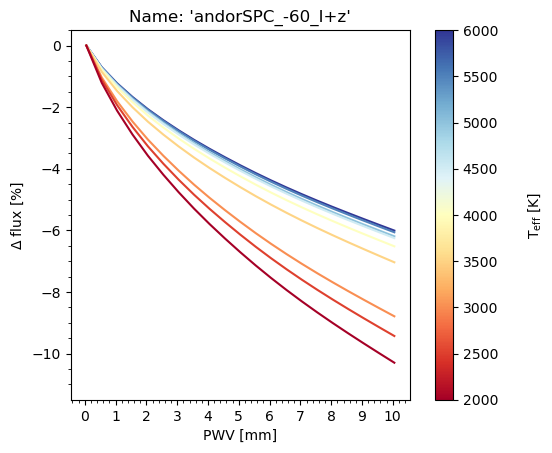

In [7]:
fig, ax = umbrella.deltaFluxPlot(coords, data, name)
ax.set_ylim(-11.5,0.5)
fig.savefig('./results/' + name + '_deltaFlux.pdf')
print('./results/' + name + '_pwvGrid_data.npy')

---

## Example night and model demonstration

In [8]:
## read in example file
example_night = pd.read_csv('./datafiles/SPCexample.csv')

jd = example_night.jd
lc = example_night.lc
airmass = example_night.airmass
pwv = example_night.pwv

In [9]:
## model PWV induced light curve and correct
target = umbrella.interp(coords, data, pwv, airmass, 2700)
alc = umbrella.interp(coords, data, pwv, airmass, 5500)
lc_pwv = (target/alc)/np.mean(target/alc)

corrected_lc = lc/lc_pwv

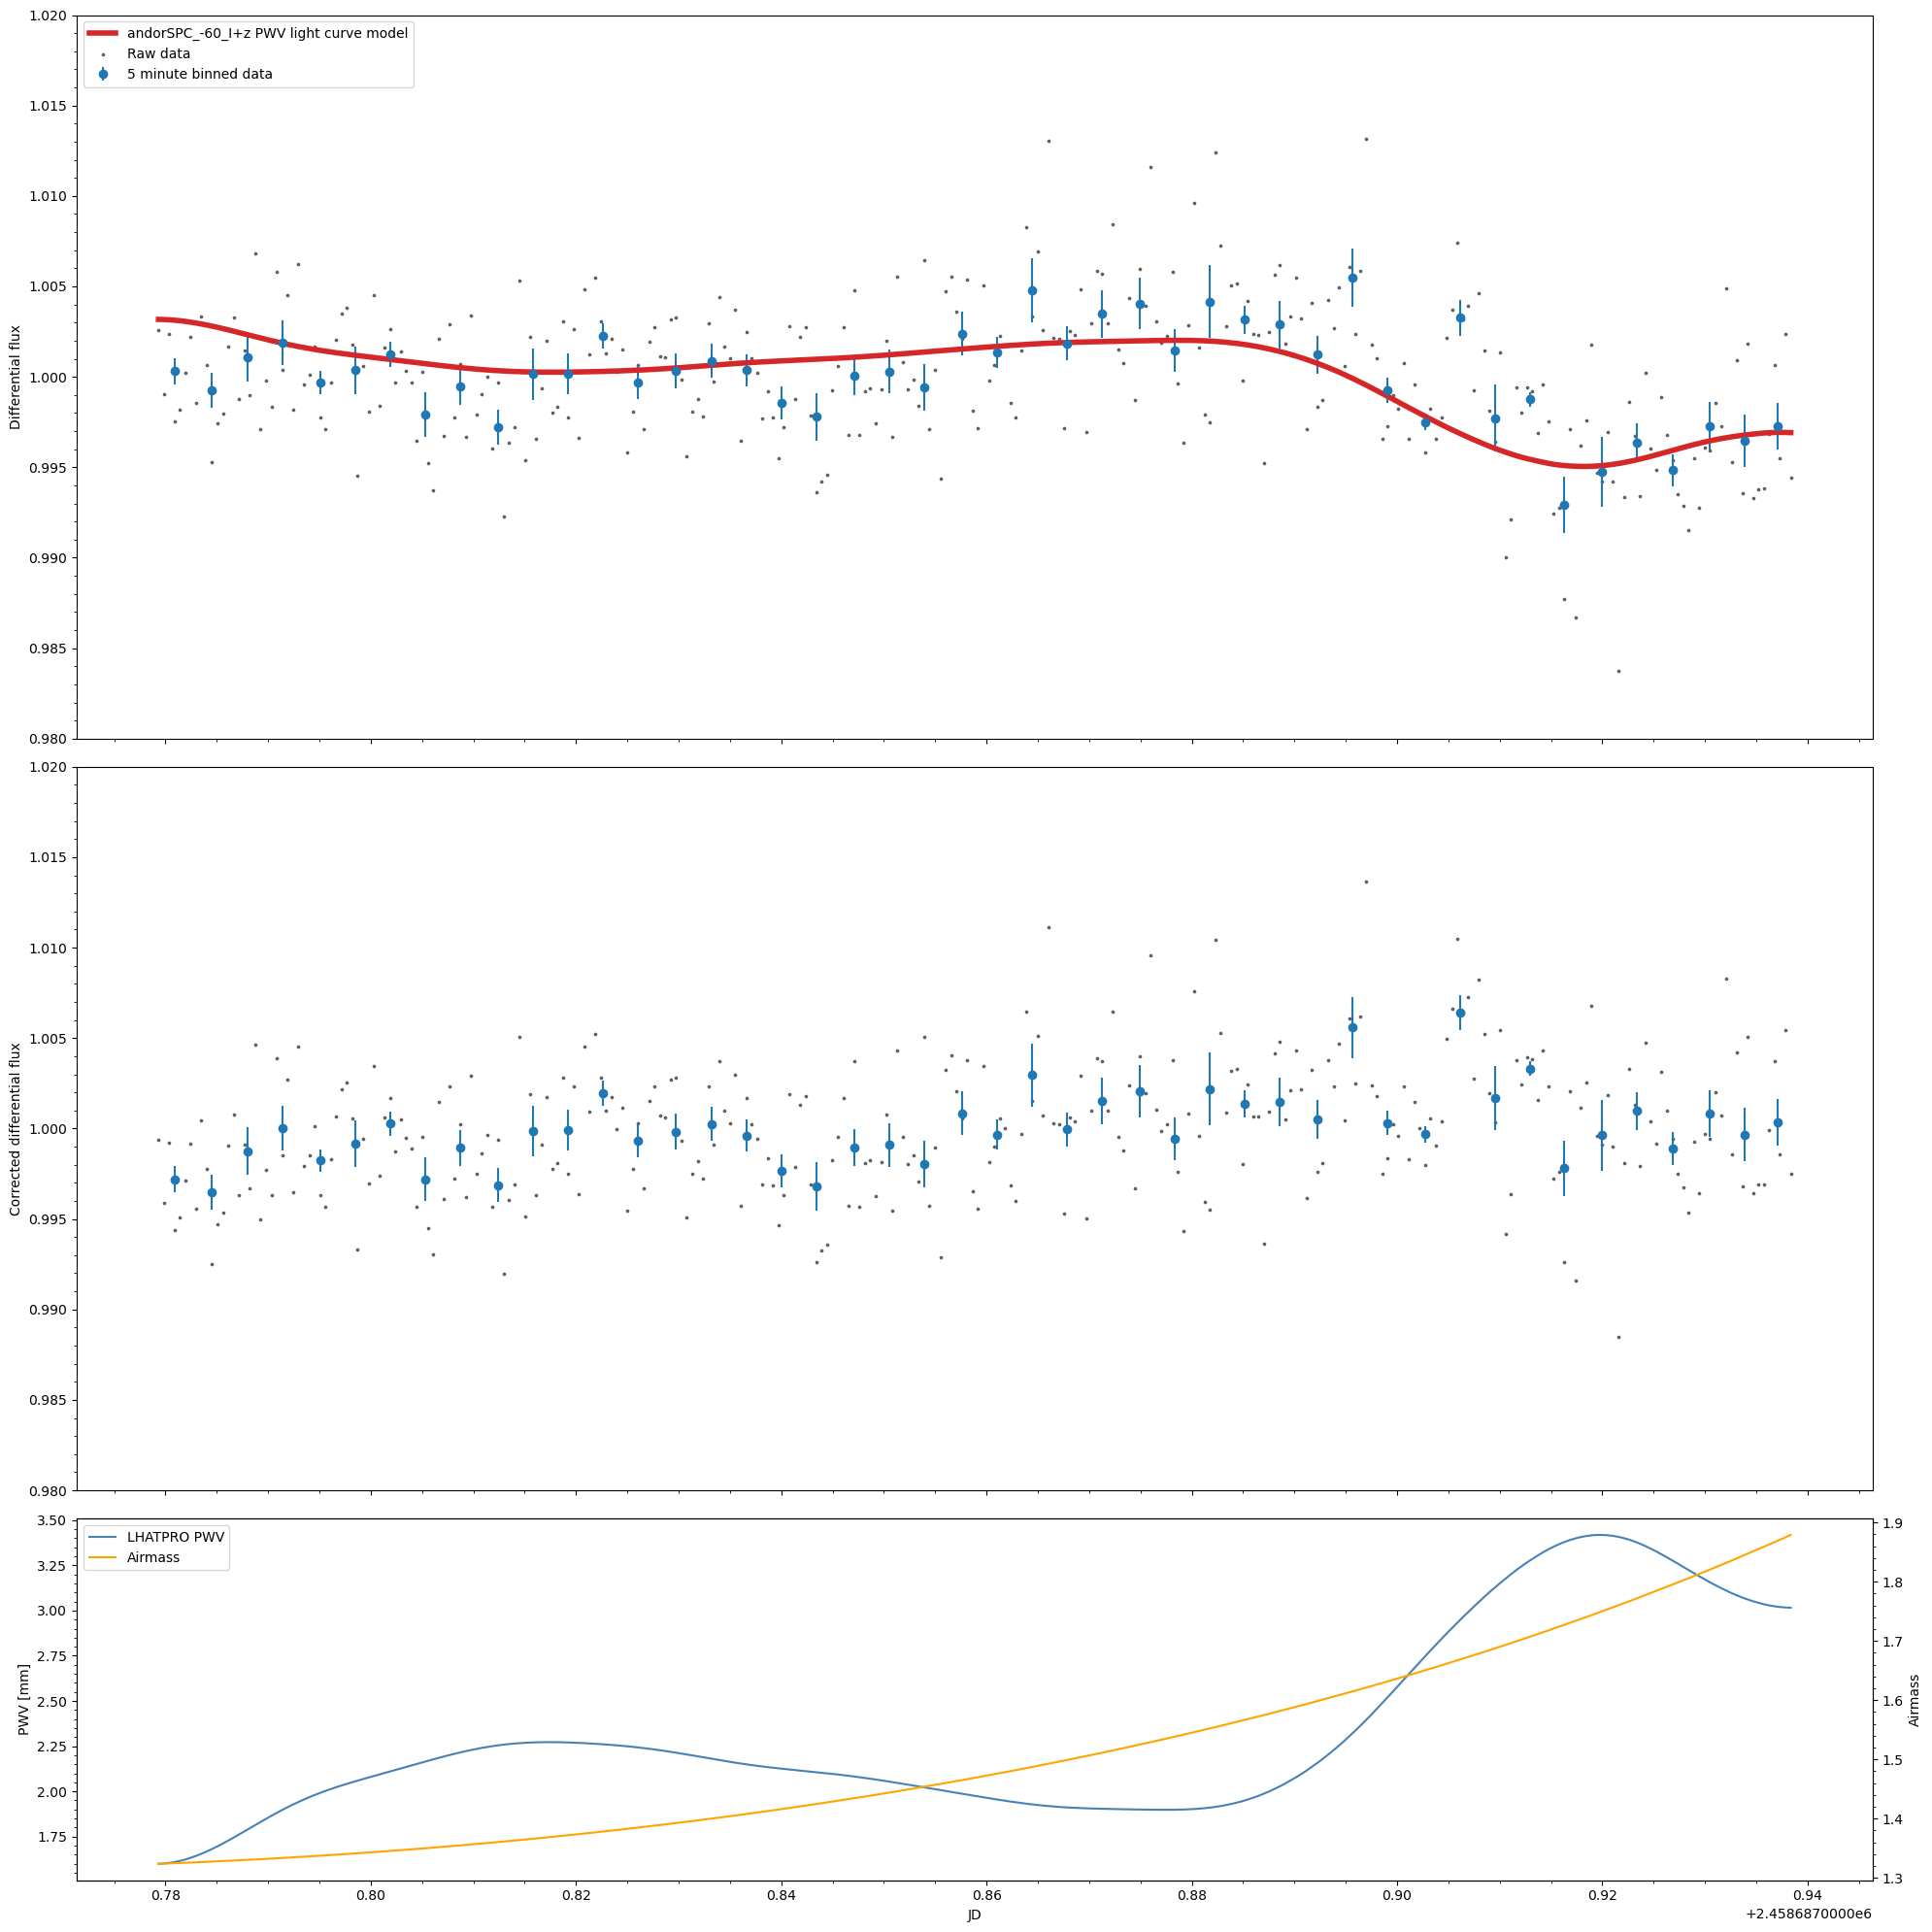

In [10]:
### plot
fig, ax = plt.subplots(3, 1, figsize=(20,20), sharex='col', gridspec_kw={'height_ratios': [4, 4, 2]})

ax[0].scatter(jd, lc, s=3, alpha=0.5, color='k', label='Raw data')
ax[0].errorbar(*umbrella.binning(np.array(jd), np.array(lc), 5/(24*60), std=True), linestyle='None', marker='o', label="5 minute binned data")
ax[0].plot(jd, lc_pwv, color='tab:red', label=name + " PWV light curve model", linewidth=4)

ax[0].set_ylim(0.98,1.02)
ax[0].set_ylabel('Differential flux')
ax[0].legend(loc='upper left')
ax[0].minorticks_on()

ax[1].scatter(jd, corrected_lc, s=3, alpha=0.5, color='k', label='Raw data')
ax[1].errorbar(*umbrella.binning(np.array(jd), np.array(corrected_lc), 5/(24*60), std=True), linestyle='None', marker='o', label="5 minute binned data")

ax[1].set_ylim(0.98,1.02)
ax[1].set_ylabel('Corrected differential flux')
ax[1].minorticks_on()

ax[2].plot(jd, pwv, color='steelblue', label='LHATPRO PWV')
ax[2].set_ylabel('PWV [mm]')
ax[2].set_xlabel('JD')
ax[2].minorticks_on()
lines, labels = ax[2].get_legend_handles_labels()

ax[2] = ax[2].twinx()
ax[2].set_ylabel('Airmass')
ax[2].plot(jd, airmass, color='orange', label='Airmass')
ax[2].minorticks_on()

lines2, labels2 = ax[2].get_legend_handles_labels()
ax[2].legend(lines + lines2, labels + labels2, loc='best')

plt.tight_layout()
fig.savefig('./results/' + name + '_example.pdf', dpi=300)